# Non-Transformed Temporal Similarity Search using KDB+

##### Note: This example requires KDB.AI Server Edition

This notebook demonstrates how to use KDB.AI's Non-Transformed Temporal Similarity Search (TSS) for pattern matching and technical analysis on an existing KDB+ HDB. 
Agenda:

1. Dependencies, Imports & Setup
2. Create Synthetic Market Time Series Data in KDB+
3. Define KDB.AI Session
4. Pattern Matching and Visualization

### 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


In [1]:
import numpy as np
import pandas as pd
import pykx as kx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.templates.default = "plotly"

## 2. Create Synthetic Market Time Series Data
Prior to starting your KDB.AI server, let's generate a KDB+ HDB 10 million data points across 10 different stocks (symbols) using a random walk. We wil have the following data:

- timestamp: The timestamp for the data
- sym: The ticket symbol of the stock being traded
- price: The price of the stock being traded at a certain timestamp
- volume: The traded volume of the stock being traded.

In [2]:
%%q

dst:`:demo_db    / database root

numpart:10;
ed:2024.08.31; / end date the last date partition
dts:{[ed;n] reverse n#d where 1<mod[d:ed-til 2*n]7}[ed;numpart];
bgn:first dts;
end:last dts;
bgntm: 09:30:00.0;  / exchange open time
endtm: 16:00:00.0;  / exchange close time

nt:100000;            / trades per stock per day
qpt:1;

\S 104831           / random seed

/ utils
pi:acos -1
accum:{prds 1.0,-1 _ x}
int01:{(til x)%x-1}
limit:{(neg x)|x & y}
minmax:{(min x;max x)}
normalrand:{(cos 2 * pi * x ? 1f) * sqrt neg 2 * log x ? 1f}
rnd:{0.01*floor 0.5+x*100}
xrnd:{exp x * limit[2] normalrand y}
randomize:{value "\\S ",string "i"$0.8*.z.p%1000000000}
shiv:{(last x)&(first x)|asc x+-2+(count x)?5}
vol:{10+`int$x?90}
vol2:{x?100*1 1 1 1 2 2 3 4 5 8 10 15 20}

/ =========================================================
choleski:{
 n:count A:x+0.0;
 if[1>=n;:sqrt A];
 p:ceiling n%2;
 X:p#'p#A;
 Y:p _'p#A;
 Z:p _'p _A;
 T:(flip Y) mmu inv X;
 L0:n #' (choleski X) ,\: (n-1)#0.0;
 L1:choleski Z-T mmu Y;
 L0,(T mmu p#'L0),'L1}

/ =========================================================
/ paired correlation, matrix of variates, min 0.1 coeff
choleskicor:{
 x:"f"$x;y:"f"$y;
 n:count y;
 c:0.1|(n,n)#1.0,x,((n-2)#0.0),x;
 (choleski c) mmu y}

/ =========================================================
/ volume profile - random times, weighted toward ends
/ x=count
volprof:{
 p:1.75;
 c:floor x%3;
 b:(c?1.0) xexp p;
 e:2-(c?1.0) xexp p;
 m:(x-2*c)?1.0;
 {(neg count x)?x} m,0.5*b,e}

/ =========================================================
write:{
 t:.Q.en[dst] update sym:`p#sym from `sym xasc y;
  (` sv dst,`$x) set t}

/ symbol data for tick demo
sn:2 cut (
  `AAPL;218;
  `TSLA;210;
  `GOOG;135;
  `AMZN;145;
  `MSFT;332;
  `NVDA;458;
  `META;517;
  `NFLX;412;
  `ADBE;555;
  `PYPL;65
  )

s:first each sn
p:last each sn

/ gen
vex:1.0005         / average volume growth per day
ccf:0.5            / correlation coefficient

/ =========================================================
/ qx index, qb/qbb/qa/qba margins, qp price, qn position
batch:{[x;len]
  p0:prices[;x];
  p1:prices[;x+1];
  d:xrnd[0.0003] len;
  qx::0N?raze {(floor len%cnt)#x} each til cnt;
  qb::rnd len?1.0;
  qa::rnd len?1.0;
  qbb::qb & -0.02 + rnd len?1.0;
  qba::qa & -0.02 + rnd len?1.0;
  n:where each qx=/:til cnt;
  s:p0*accum each d n;
  s:s + (p1-last each s)*{int01 count x} each s;
  qp::len#0.0;
  (qp n):rnd s;
  qn::0
 }

/ =========================================================
/ constrained random walk
/ x max movement per step
/ y max movement at any time (above/below)
/ z number of steps
cgen:{
  m:reciprocal y;
  while[any (m>p) or y<p:prds 1.0+x*normalrand z];
  p}

/ =========================================================
getdates:{
 b:x 0;
 e:x 1;
 d:b + til 1 + e-b;
 d where 5> d-`week$d
 }

/ =========================================================
makeprices:{
 r:cgen[0.0375;3] each cnt#nd;
 r:choleskicor[ccf;1,'r];
 (p % first each r) * r *\: 1.1 xexp int01 nd+1}

/ =========================================================
/ day volumes
makevolumes:{x#1}

/ main
cnt:count s
dates:getdates bgn,end
nd:count dates

prices:makeprices nd + 1
volumes:floor (cnt*nt) * makevolumes nd

calcvols:{[vols;x]
  len::vols x;
  batch[x;len];
 }

day:{

  sa:string dx:dates x;
  show"Creating Partition for ",sa;
  / trade table
  calcvols[volumes;x];
  maxtime:max floor (endtm-bgntm)*volprof count qx;
  tvol:$[(count qx)>maxtime;(count qx);(neg count qx)];
  r:asc bgntm+tvol?maxtime;
  cx:0N?raze {(floor len%qpt)#x} each til qpt;
  cn:count n:where cx<qpt;
  t:([]sym:s qx n;time:dx+shiv r n;price:qp n;size:vol cn);
  write[sa,"/trade/";t]
 }

day each til nd;

1"\n\nCreated Sample HDB.\n\n";

"Creating Partition for 2024.08.19"
"Creating Partition for 2024.08.20"
"Creating Partition for 2024.08.21"
"Creating Partition for 2024.08.22"
"Creating Partition for 2024.08.23"
"Creating Partition for 2024.08.26"
"Creating Partition for 2024.08.27"
"Creating Partition for 2024.08.28"
"Creating Partition for 2024.08.29"
"Creating Partition for 2024.08.30"


Created Sample HDB.



## 3. Start KDB.AI Server and Define KDB.AI Session
To start a KDB.AI session using on disk data you should start your local KDB.AI Server with a volume mount to the location of your data (demo_db). 
```
docker run -it          \
    -p 8082:8082        \
    -e KDB_LICENSE_B64  \
    -v ./demo_db:/db    \
    ext-dev-registry.kxi-dev.kx.com/kdbai-db:1.4.0
```

In [3]:
%%q
\c 15 160
// system"S ",string `int$.z.t
\s

gw:hopen 8082 // Open q IPC connection to KDB.AI Server

16i


In [4]:
%%q

// Check if the table already exist and delete if so
res:gw(`listTables;enlist[`database]!enlist`default);
if[`trade in (res . `result`tables);
   gw(`deleteTable;`database`table!`default`trade)];

res:gw(`createTable;`database`table`externalDataReferences!(`default;`trade;enlist `path`provider!("/db";`kx)));
res`result

database              | `default
table                 | `trade
partition             | 1b
rowCount              | 10000000
schema                | +`name`type`attributes!(`date`sym`time`price`size;"dspfj";`````)
partitionColumn       | `date
externalDataReferences| ,+`path`provider!(,"/db";,`kx)
index                 | ()
compression           | ()


We can use the `getData` function to query the data, applying the `agg` and `groupBy` options to retrieve a count of records grouped by symbol.

In [5]:
%%q

res:gw(`query;`database`table`groupBy`aggs!(`default;`trade;`sym;enlist[`countBySym]!enlist(`count;`sym)));
res`result

sym  countBySym
---------------
AAPL 1000000   
ADBE 1000000   
AMZN 1000000   
GOOG 1000000   
META 1000000   
MSFT 1000000   
NFLX 1000000   
NVDA 1000000   
PYPL 1000000   
TSLA 1000000   


### 4. Pattern Matching and Visualization

In this section, we will perform pattern matching using predefined stock price patterns.

1. **Define Patterns**: Start by defining each pattern in Q.

2. **Similarity Search**: Conduct a similarity search for each pattern of varying lengths against the synthetic market time series data stored in the HDB. This process involves querying the database to find the sequence most similar to our predefined patterns.

3. **Outlier Search**: Perform an outlier search for each normalised pattern against the synthetic market time series data in the HDB. This step queries the database for the sequence that is least similar to the patterns.

4. **Visualisation**: For each pattern, visualise both the normalised synthetic pattern and the most similar pattern found in the synthetic data. This visual representation aids in evaluating the performance of the similarity search.

5. **Result Analysis**: The results of the similarity search are printed, showing the most similar timestamp and pattern from the synthetic data. We then attempt to map these findings back to the original synthetic data to verify and assess the similarity.

This approach can be used to leverage synthetic price movements in identifying significant price trends within real data.


In [6]:
%%q

axpb:{[a;b;x] b+a*x}

// With all shapeX functions below, N needs to be like 6*2^x

patternA:{[N] 
    s:ceiling N%6;
    legs:enlist[0],s cut 1+til N;
    funcs:(::;axpb[2;0;];axpb[-1;3*s;];axpb[2;-3*s;];axpb[-2;9*s;];axpb[1;-3*s;];axpb[-2;12*s;]);
    "f"$ (,/) {first[x]@last x} each flip (funcs; legs)}

patternB:{[N] // N like 6*2^x
    s:ceiling N%6;
    legs:enlist[0],s cut 1+til N;
    funcs:(::;axpb[2;0;];axpb[2;0;];axpb[-1;6*s;];axpb[1;0;];axpb[-2;12*s;];axpb[-2;12*s;]);
    "f"$ (,/) {first[x]@last x} each flip (funcs; legs)}

patternC:{[N] 
    s:ceiling N%6;
    legs:enlist[0],s cut 1+til N;
    funcs:(::;axpb[2;0;];axpb[-1.5;3.5*s;];axpb[1.5;-2.5*s;];axpb[-1.5;6.5*s;];axpb[1.5;-5.5*s;];axpb[-2;12*s;]);
    "f"$ (,/) {first[x]@last x} each flip (funcs; legs)}

patternD:{[N] 
    s:ceiling N%6;
    legs:enlist[0],s cut 1+til N;
    funcs:(::;axpb[1;0;];axpb[-0.5;1.5*s;];axpb[2;-3.5*s;];axpb[-2;8.5*s;];axpb[0.5;-1.5*s;];axpb[-1;6*s;]);
    "f"$ (,/) {first[x]@last x} each flip (funcs; legs)}

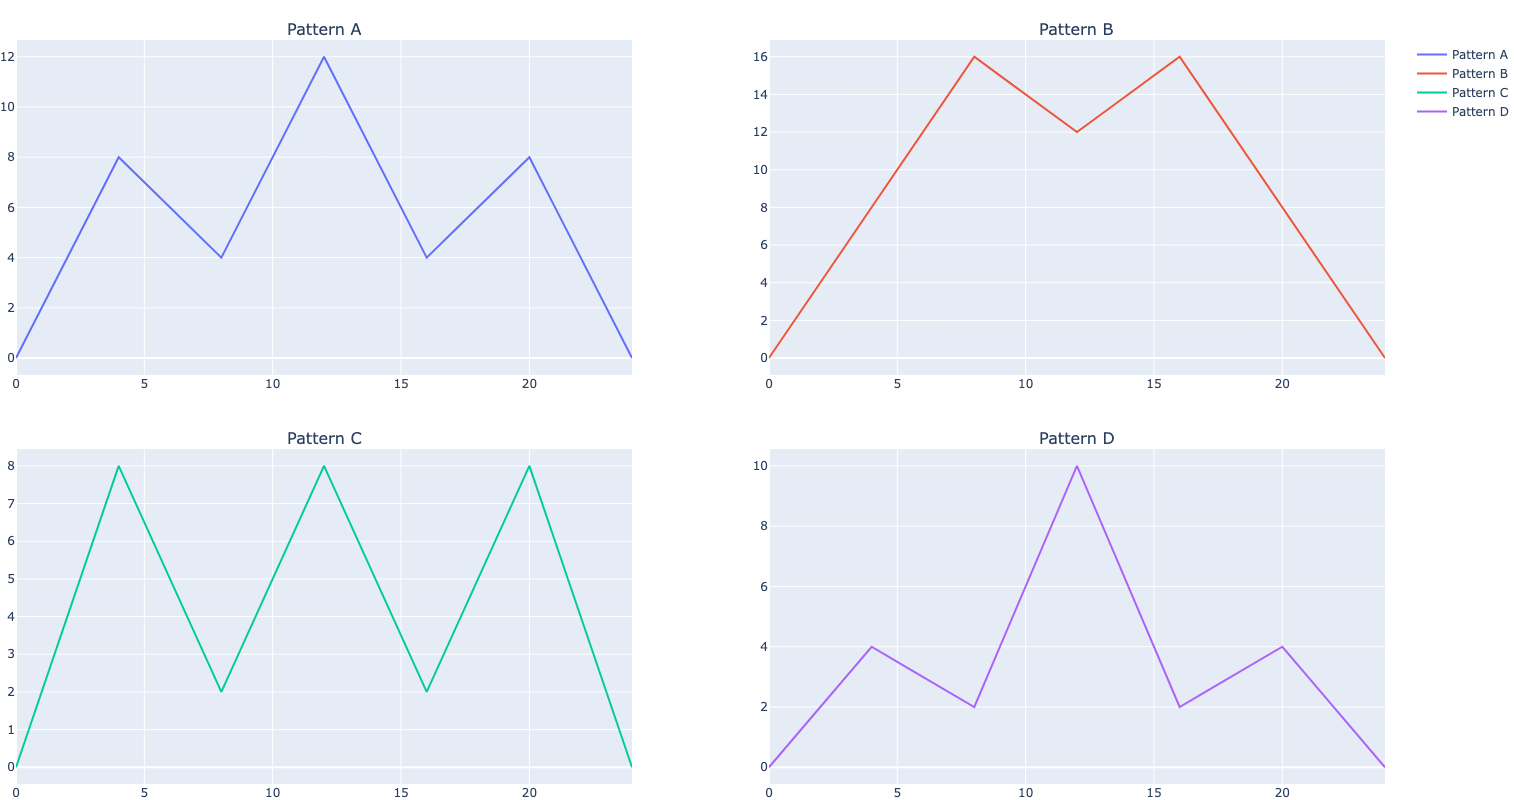

In [7]:
N = 24

fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=("Pattern A", "Pattern B", "Pattern C", "Pattern D"), 
    vertical_spacing=0.1
)

fig.add_trace(go.Scatter(mode='lines', y=kx.q('patternA', N).np(), name='Pattern A'), row=1, col=1)
fig.add_trace(go.Scatter(mode='lines', y=kx.q('patternB', N).np(), name='Pattern B'), row=1, col=2)
fig.add_trace(go.Scatter(mode='lines', y=kx.q('patternC', N).np(), name='Pattern C'), row=2, col=1)
fig.add_trace(go.Scatter(mode='lines', y=kx.q('patternD', N).np(), name='Pattern D'), row=2, col=2)

fig.update_layout(
    height=800, 
    margin=dict(l=0, t=40, r=0, b=0)
)

fig.show()

#### 4.1 Similarity Search 

In this section, we conduct a similarity search for each of the four patterns on a single symbol (AAPL) over a specified date range, returning the five closest matches for each pattern.

In [8]:
%%q

patterns:{x 24}'[`patternA`patternB`patternC`patternD];
k:10;
filters:enlist(=;`sym;enlist`AAPL);

x:first patterns;

results:{
    res:gw(`search;`database`table`type`vectors`n`filter`options!(`default;`trade;`tss;enlist[`price]!enlist enlist x;k;filters;enlist[`returnMatches]!enlist 1b));
    first res`result } each patterns;

results

+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.23 2024.08.27 2024.08.28 2024.08.22 2024.08.29 2024.08.20 2024.08.30 2024.08.22 2024.08.22 2024.08.2..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.21 2024.08.22 2024.08.21 2024.08.19 2024.08.27 2024.08.30 2024.08.28 2024.08.19 2024.08.20 2024.08.2..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.30 2024.08.30 2024.08.30 2024.08.29 2024.08.22 2024.08.22 2024.08.22 2024.08.20 2024.08.28 2024.08.2..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.28 2024.08.28 2024.08.28 2024.08.19 2024.08.23 2024.08.30 2024.08.29 2024.08.20 2024.08.27 2024.08.2..


Define the python functions to plot dataframes / graphs

In [9]:
# Function to process a pattern
def process_pattern(pattern_res, pattern_p):
    # Convert pattern result to DataFrame
    pattern_df = kx.q(pattern_res).pd()

    # Combine 'sym' and 'time' into one column
    sym_time = pattern_df['sym'] + ' ' + pattern_df['time'].astype(str)

    # Convert 'nnMatch' to DataFrame and adjust columns
    nnMatch_df = pd.DataFrame(np.stack(pattern_df['nnMatch'].values).T)
    nnMatch_df.columns = sym_time

    # Normalise the pattern
    q = kx.q(pattern_p).np()
    q = (q - q.mean()) / q.std()

    # Normalize the nnMatch_df
    for c in nnMatch_df.columns:
        nnMatch_df[c] = (nnMatch_df[c] - nnMatch_df[c].mean()) / nnMatch_df[c].std()

    # Return both the original and nnMatch_df
    return pattern_df, nnMatch_df, q


# Function to plot the pattern and its corresponding nearest neighbour matches
def plot_pattern(nnMatch_df, q, pattern_name):
    fig = px.line(nnMatch_df, height=600, render_mode='webgl')
    
    # Define a colour sequence for the traces
    color_sequence = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown']
    
    # Update the traces' line colours and opacity
    for i, trace in enumerate(fig.data):
        trace.update(line=dict(color=color_sequence[i % len(color_sequence)]), opacity=0.3)
    
    # Add the pattern 'q' as an additional trace
    fig.add_trace(go.Scattergl(
        mode='lines',
        y=q,
        line=dict(width=3, color='orange'),
        name=pattern_name
    ))
    
    # Update layout for better visualization
    fig.update_layout(
        hovermode='closest',
        title=f'{pattern_name} Plot',
        xaxis_title='Index',
        yaxis_title='Value'
    )
    
    return fig

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-23  AAPL 2024-08-23 14:38:41.571  238.66    82  79172  1.785228   
1 2024-08-27  AAPL 2024-08-27 13:55:08.851  273.48    25  68064  2.179401   
2 2024-08-28  AAPL 2024-08-28 13:32:39.735  265.46    20  62436  2.191350   
3 2024-08-22  AAPL 2024-08-22 15:59:12.574  246.93    43  99800  2.238873   
4 2024-08-29  AAPL 2024-08-29 14:11:50.317  291.01    82  72220  2.298780   

                                             nnMatch  
0  [238.66, 238.62, 238.75, 238.89000000000001, 2...  
1  [273.48, 273.58, 273.63, 273.75, 273.82, 273.7...  
2  [265.46, 265.45, 265.59000000000003, 265.62, 2...  
3  [246.93, 247.05, 247.07, 247.23000000000002, 2...  
4  [291.01, 291.11, 291.22, 291.31, 291.31, 291.2...  


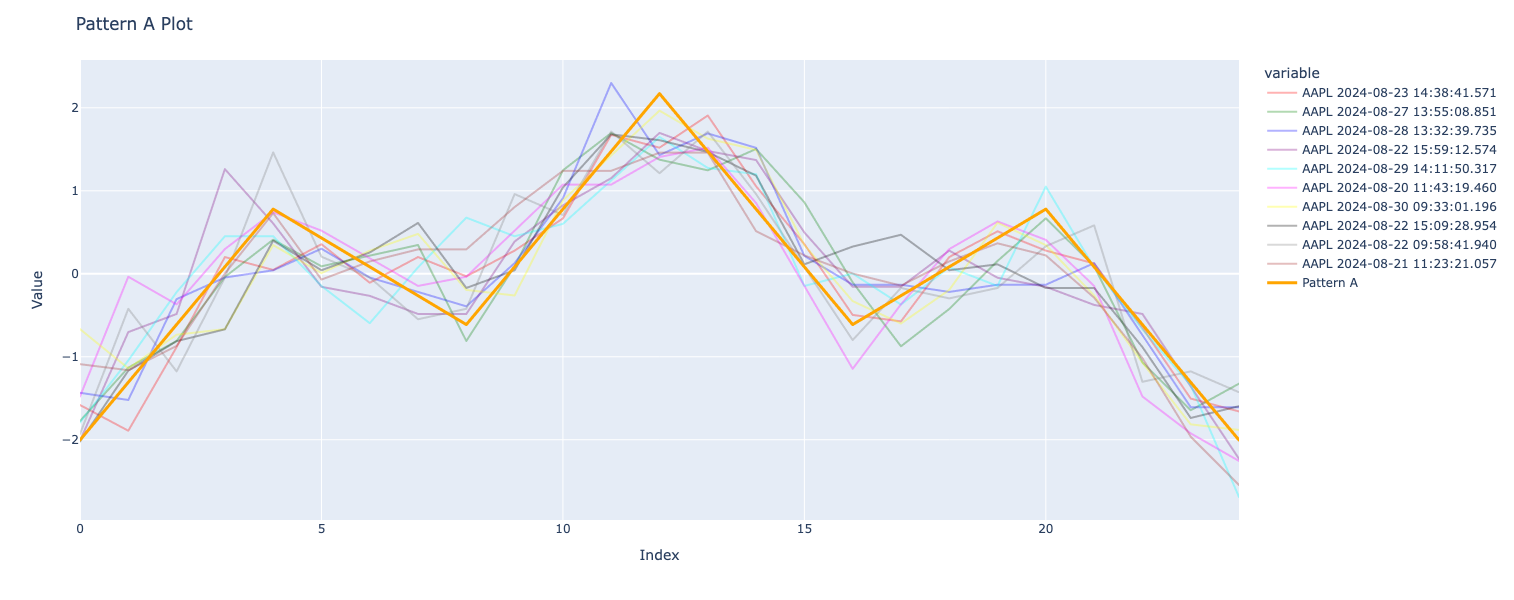

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-21  AAPL 2024-08-21 11:50:07.309  218.24    46  35815  1.052655   
1 2024-08-22  AAPL 2024-08-22 11:59:24.140  268.93    40  38175  1.316181   
2 2024-08-21  AAPL 2024-08-21 10:04:34.018  230.41    28   9064  1.326923   
3 2024-08-19  AAPL 2024-08-19 15:10:19.251  230.77    76  87237  1.333702   
4 2024-08-27  AAPL 2024-08-27 14:24:44.317  270.15    60  75693  1.347826   

                                             nnMatch  
0  [218.24, 218.24, 218.35, 218.46, 218.43, 218.5...  
1  [268.93, 268.95, 269.03000000000003, 269.16, 2...  
2  [230.41, 230.48000000000002, 230.5, 230.47, 23...  
3  [230.77, 230.86, 230.89000000000001, 230.94, 2...  
4  [270.15, 270.23, 270.3, 270.28000000000003, 27...  


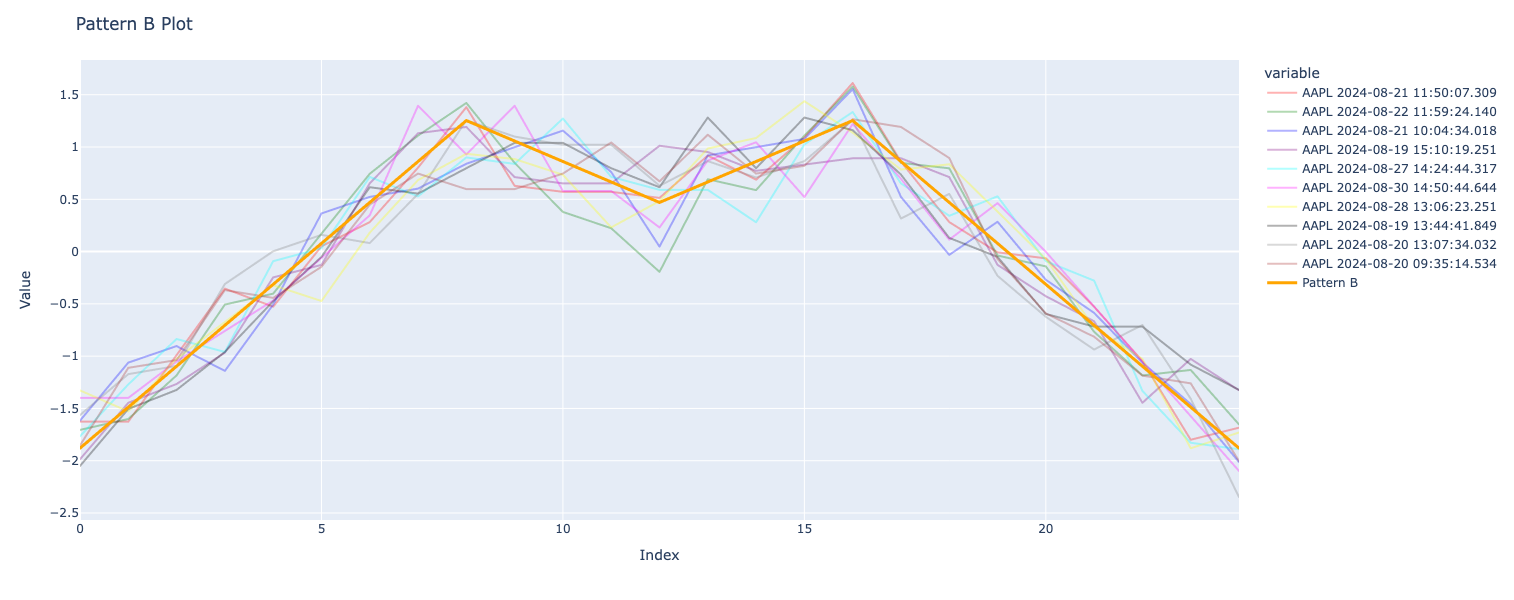

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-30  AAPL 2024-08-30 13:51:28.393  287.94    94  67000  2.483461   
1 2024-08-30  AAPL 2024-08-30 12:11:54.392  285.74    21  41620  2.523976   
2 2024-08-30  AAPL 2024-08-30 15:11:33.190  272.54    34  87387  2.707857   
3 2024-08-29  AAPL 2024-08-29 12:09:06.327  304.38    59  40849  2.790505   
4 2024-08-22  AAPL 2024-08-22 10:54:49.737  249.41    70  21590  2.865306   

                                             nnMatch  
0  [287.94, 288.03000000000003, 288.11, 288.2, 28...  
1  [285.74, 285.78000000000003, 285.92, 285.93, 2...  
2  [272.54, 272.55, 272.64, 272.81, 272.76, 272.8...  
3  [304.38, 304.32, 304.31, 304.5, 304.49, 304.53...  
4  [249.41, 249.56, 249.67000000000002, 249.77, 2...  


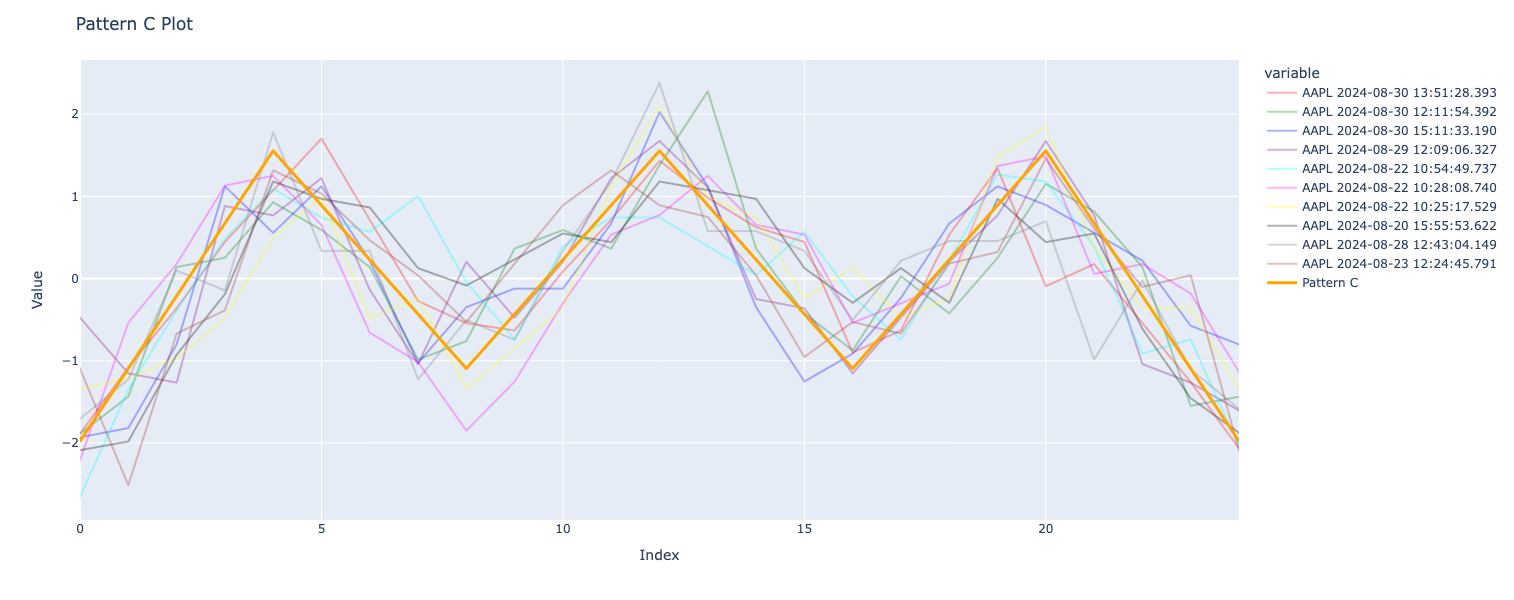

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-28  AAPL 2024-08-28 13:06:54.309  271.58    80  55839  1.658340   
1 2024-08-28  AAPL 2024-08-28 12:53:53.150  270.49    88  52462  1.830688   
2 2024-08-28  AAPL 2024-08-28 13:32:39.735  265.46    20  62436  1.913840   
3 2024-08-19  AAPL 2024-08-19 14:19:11.772  225.32    18  74090  2.009611   
4 2024-08-23  AAPL 2024-08-23 14:38:41.571  238.66    82  79172  2.094666   

                                             nnMatch  
0  [271.58, 271.7, 271.56, 271.72, 271.76, 271.74...  
1  [270.49, 270.56, 270.56, 270.64, 270.69, 270.7...  
2  [265.46, 265.45, 265.59000000000003, 265.62, 2...  
3  [225.32, 225.39000000000001, 225.37, 225.5, 22...  
4  [238.66, 238.62, 238.75, 238.89000000000001, 2...  


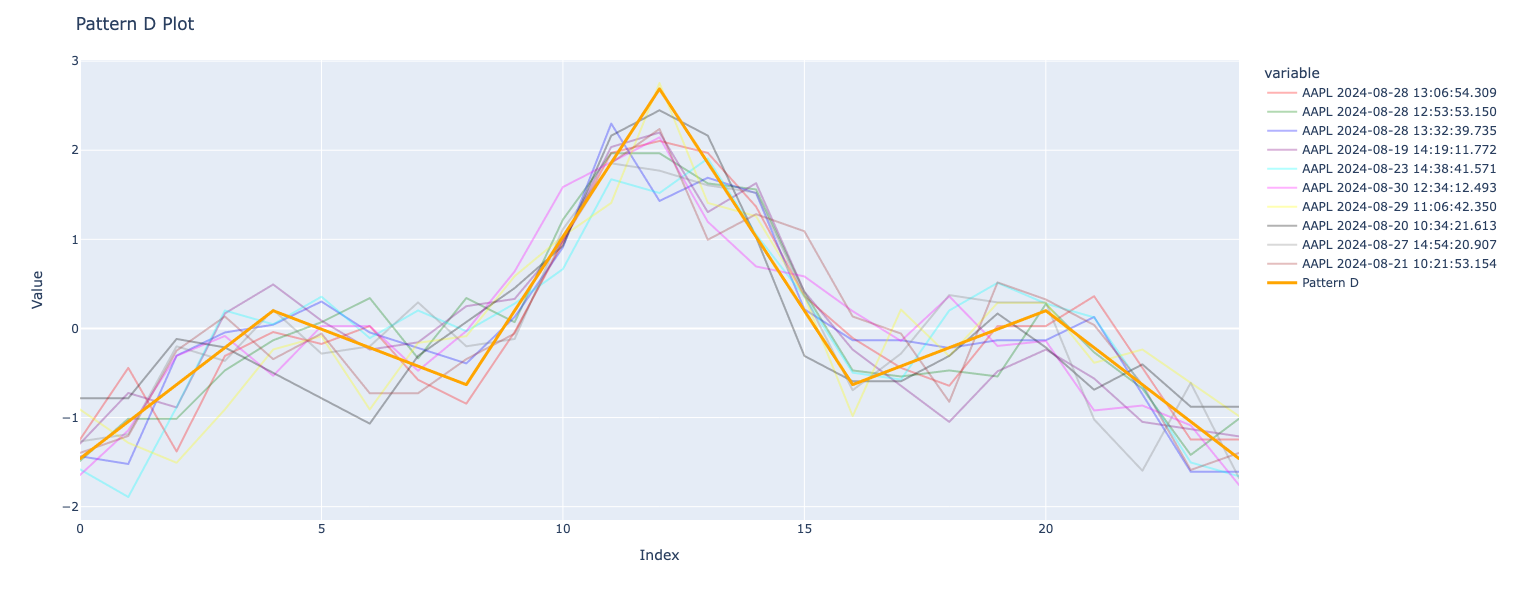

In [10]:
# List of pattern result names and pattern names
pattern_results = ['results[0]', 'results[1]', 'results[2]', 'results[3]']
pattern_names = ['Pattern A', 'Pattern B', 'Pattern C', 'Pattern D']
pattern_p = ['patterns[0]', 'patterns[1]', 'patterns[2]', 'patterns[3]']

# Process and plot each pattern in a loop
for i in range(4):
    pattern_df, nnMatch_df, q = process_pattern(pattern_results[i], pattern_p[i])
    
    # Plot using the normalized nnMatch_df
    print(pattern_df.head())
    fig = plot_pattern(nnMatch_df, q, pattern_names[i])
    fig.show()

##### 4.1 Similarity Search - Chunk Results

We perform a similarity search to retrieve the nearest neighbour for each individual symbol in our database. This is accomplished by conducting the search on a per-symbol basis, then joining and re-ordering the results based on the nearest neighbour distance (`nnDist`)

In [11]:
%%q

pattern:patternA 24;
k:1;
filters:{(enlist(=;`sym;enlist x))} each `AAPL`ADBE`AMZN`GOOG`META`MSFT`NFLX`NVDA`PYPL`TSLA;

\ts results: `nnDist xasc raze {
    res:gw(`search;`database`table`type`vectors`n`filter`options!(`default;`trade;`tss;enlist[`price]!enlist enlist pattern;k;x;enlist[`returnMatches]!enlist 1b));
    first res`result } each filters;

results

5129 19536
date       sym  time                          price  size nnIdx  nnDist   nnMatch                                                                            ..
-------------------------------------------------------------------------------------------------------------------------------------------------------------..
2024.08.28 TSLA 2024.08.28D15:47:23.385000000 225.17 75   996703 1.725705 225.17 225.3  225.39 225.43 225.51 225.47 225.45 225.46 225.41 225.51 225.54 225.68..
2024.08.26 MSFT 2024.08.26D14:10:00.318000000 314.95 86   571625 1.73263  314.95 315.06 315.22 315.35 315.41 315.36 315.28 315.3  315.19 315.31 315.46 315.41..
2024.08.23 AAPL 2024.08.23D14:38:41.571000000 238.66 82   79172  1.785228 238.66 238.62 238.75 238.89 238.87 238.91 238.85 238.89 238.86 238.9  238.95 239.08..
2024.08.30 GOOG 2024.08.30D12:30:10.196000000 152.43 82   346171 1.838441 152.43 152.45 152.54 152.57 152.56 152.58 152.57 152.56 152.55 152.53 152.63 152.65..
2024.08.20 NVDA 2024.08.20D14

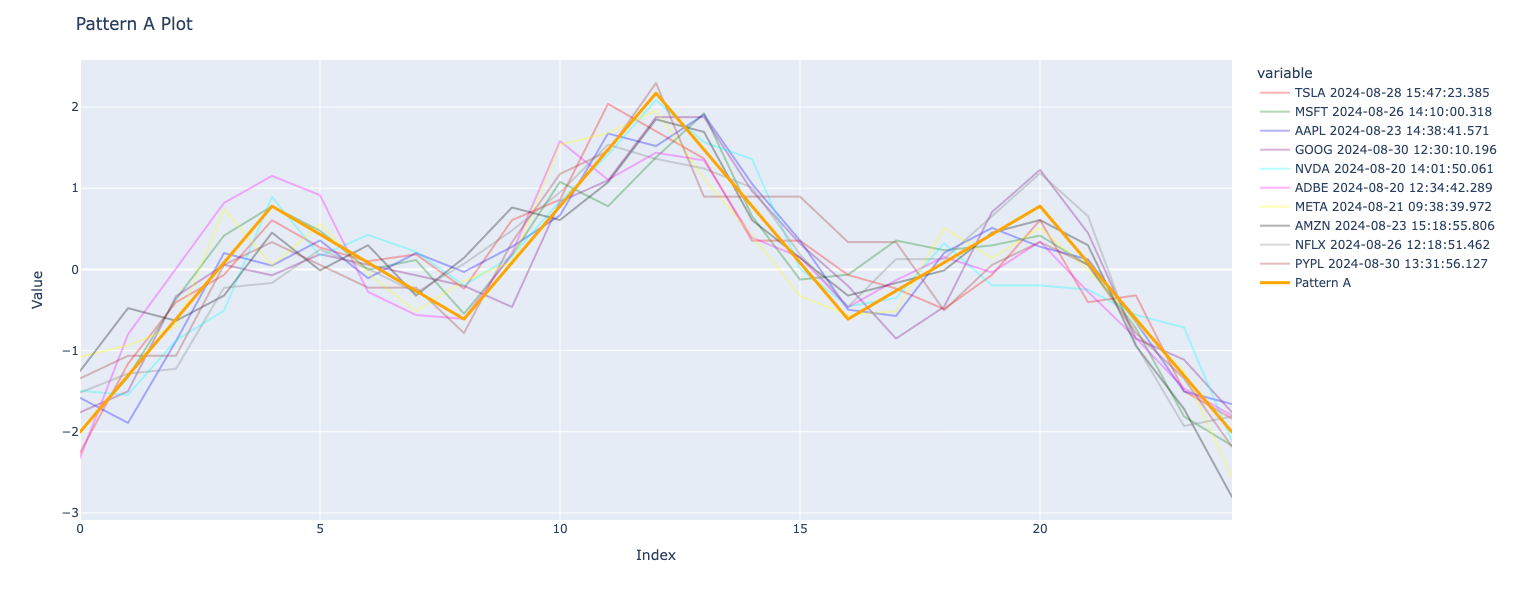

In [12]:
# Process the pattern and nearest neighbours
pattern_df, nnMatch_df, q = process_pattern('results', 'pattern')

# Plot the result
fig = plot_pattern(nnMatch_df, q, 'Pattern A')

# Show the figure
fig.show()

#### 4.3 Search for Outliers

Another key feature of Non-Transformed Temporal Similarity Search is outlier detection, which identifies the most dissimilar vectors.

To perform this search, set 𝑛 to the negative value of the number of dissimilar results you want to retrieve (e.g. 𝑛 = −5). Additionally, modifying the pattern length will adjust the sliding window range used during the search.

In [13]:
%%q

patterns:{x 24}'[`patternA`patternB`patternC`patternD];
k:-10;
filters:enlist(=;`sym;enlist`AAPL);

x:first patterns;

results:{
    res:gw(`search;`database`table`type`vectors`n`filter`options!(`default;`trade;`tss;enlist[`price]!enlist enlist x;k;filters;enlist[`returnMatches]!enlist 1b));
    first res`result } each patterns;

results

+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.19 2024.08.21 2024.08.28 2024.08.30 2024.08.23 2024.08.26 2024.08.27 2024.08.29 2024.08.20 2024.08.2..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.30 2024.08.20 2024.08.26 2024.08.27 2024.08.28 2024.08.30 2024.08.28 2024.08.23 2024.08.23 2024.08.2..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.26 2024.08.29 2024.08.29 2024.08.20 2024.08.19 2024.08.27 2024.08.20 2024.08.30 2024.08.20 2024.08.1..
+`date`sym`time`price`size`nnIdx`nnDist`nnMatch!(2024.08.21 2024.08.26 2024.08.29 2024.08.19 2024.08.30 2024.08.26 2024.08.23 2024.08.27 2024.08.30 2024.08.1..


        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-19  AAPL 2024-08-19 13:10:26.422  228.99    22  56449  9.821290   
1 2024-08-21  AAPL 2024-08-21 14:55:02.631  234.16    44  83560  9.764492   
2 2024-08-28  AAPL 2024-08-28 09:35:32.134  271.85    63   1456  9.751531   
3 2024-08-30  AAPL 2024-08-30 15:09:44.335  274.52    91  86932  9.739841   
4 2024-08-23  AAPL 2024-08-23 11:20:38.618  253.18    86  28384  9.734983   

                                             nnMatch  
0  [228.99, 228.84, 228.78, 228.79, 228.71, 228.7...  
1  [234.16, 234.18, 234.14000000000001, 234.09, 2...  
2  [271.85, 271.87, 271.82, 271.7, 271.65, 271.63...  
3  [274.52, 274.55, 274.49, 274.42, 274.37, 274.3...  
4  [253.18, 253.1, 253.08, 252.96, 252.9200000000...  


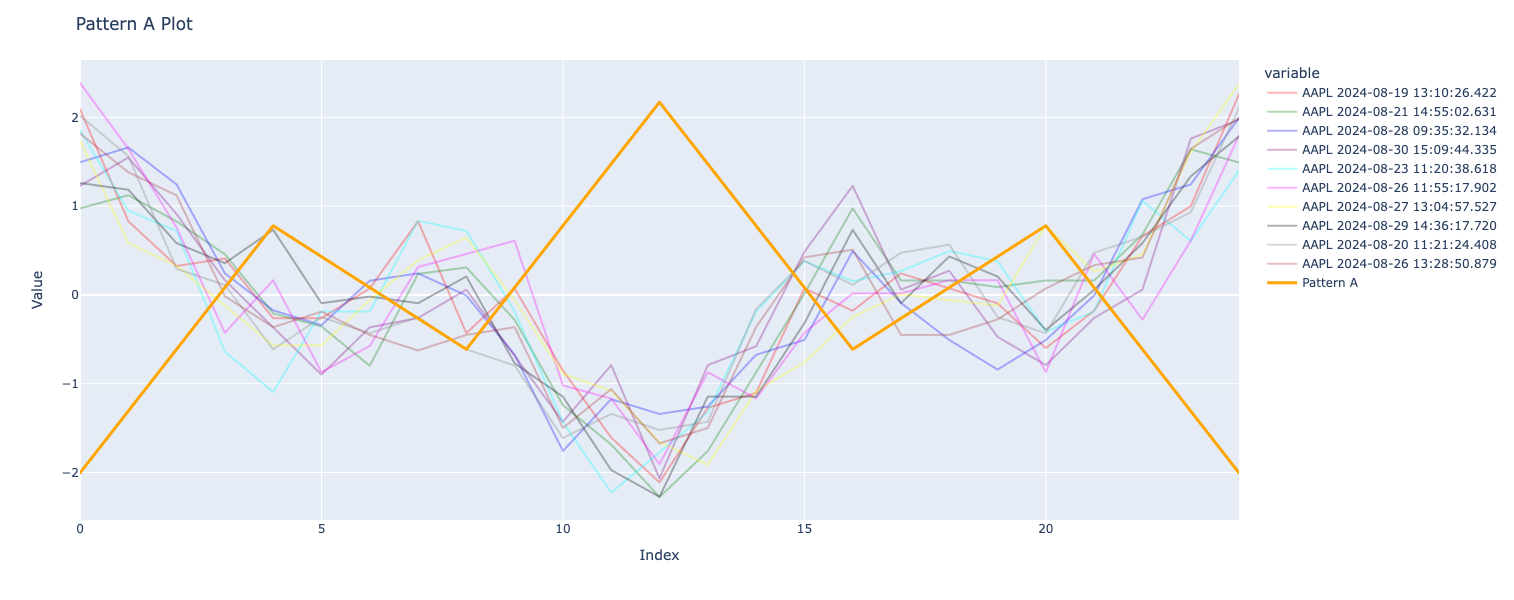

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-30  AAPL 2024-08-30 12:43:51.823  273.39    23  49815  9.937913   
1 2024-08-20  AAPL 2024-08-20 10:02:51.970  231.34    93   8383  9.932044   
2 2024-08-26  AAPL 2024-08-26 10:33:09.499  229.52    71  16140  9.927187   
3 2024-08-27  AAPL 2024-08-27 11:56:33.205  259.51    59  37659  9.912608   
4 2024-08-28  AAPL 2024-08-28 10:33:58.119  281.67    18  16526  9.912595   

                                             nnMatch  
0  [273.39, 273.35, 273.28000000000003, 273.2, 27...  
1  [231.34, 231.29, 231.23000000000002, 231.22, 2...  
2  [229.52, 229.46, 229.44, 229.39000000000001, 2...  
3  [259.51, 259.49, 259.35, 259.3, 259.31, 259.2,...  
4  [281.67, 281.57, 281.58, 281.53000000000003, 2...  


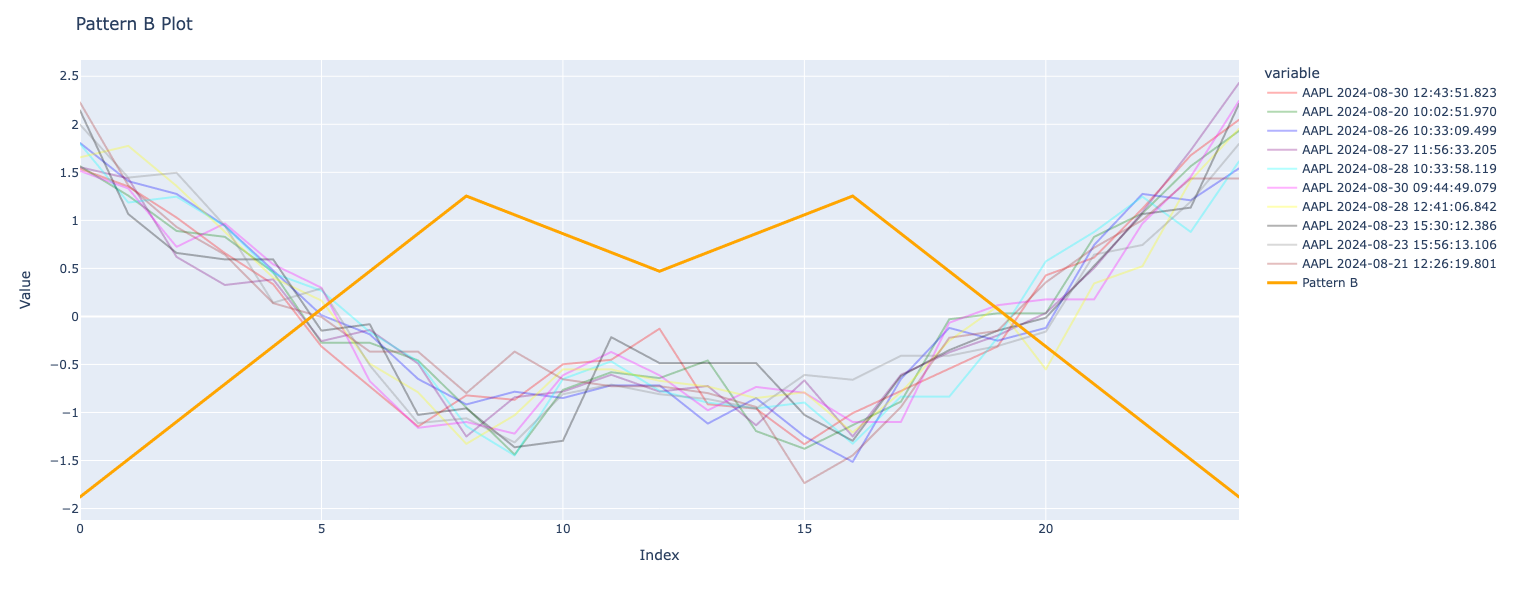

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-26  AAPL 2024-08-26 14:26:04.115  246.76    19  75984  9.678083   
1 2024-08-29  AAPL 2024-08-29 15:36:19.031  284.66    46  93962  9.672548   
2 2024-08-29  AAPL 2024-08-29 15:53:58.802  284.07    65  98451  9.664980   
3 2024-08-20  AAPL 2024-08-20 10:46:57.027  223.22    42  19782  9.651917   
4 2024-08-19  AAPL 2024-08-19 10:28:35.130  218.99    37  14829  9.606725   

                                             nnMatch  
0  [246.76000000000002, 246.73000000000002, 246.6...  
1  [284.66, 284.65000000000003, 284.47, 284.32, 2...  
2  [284.07, 284.02, 283.93, 283.86, 283.81, 283.8...  
3  [223.22, 223.23000000000002, 223.1, 222.980000...  
4  [218.99, 218.92000000000002, 218.93, 218.83, 2...  


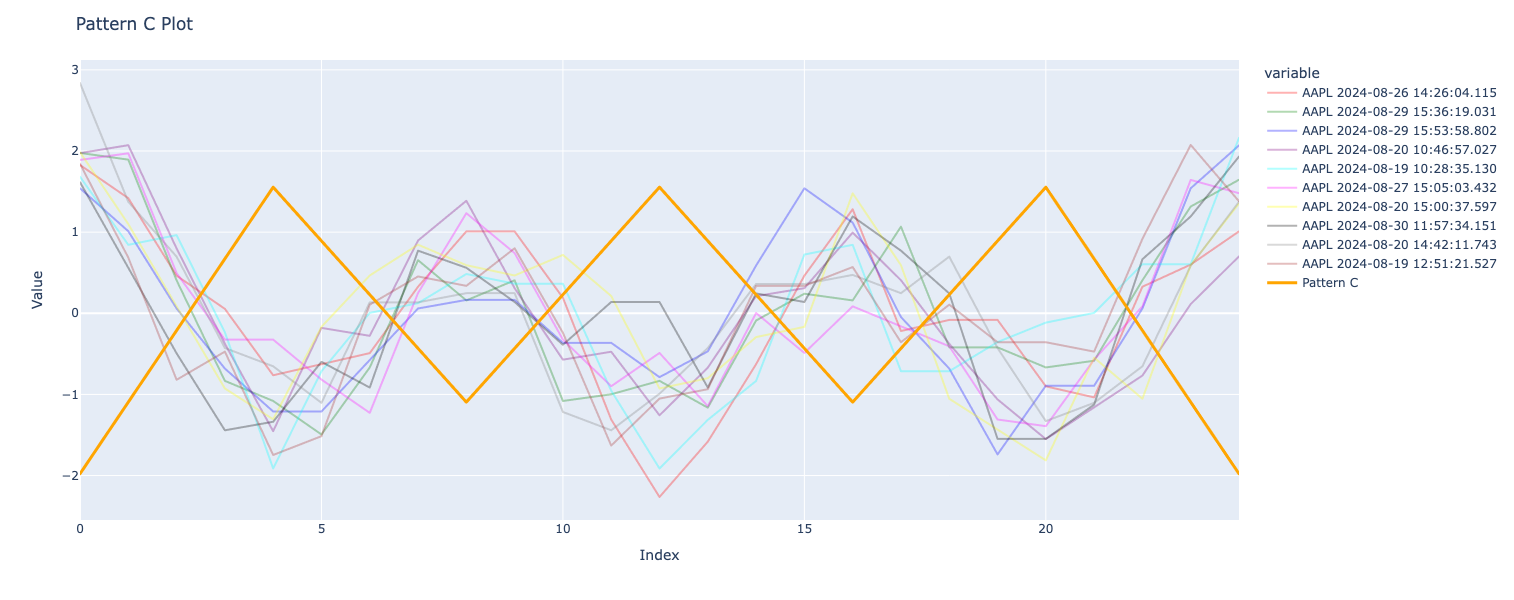

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-21  AAPL 2024-08-21 14:55:02.631  234.16    44  83560  9.864083   
1 2024-08-26  AAPL 2024-08-26 13:09:26.358  245.59    62  56505  9.855984   
2 2024-08-29  AAPL 2024-08-29 14:36:17.720  305.86    18  78382  9.838812   
3 2024-08-19  AAPL 2024-08-19 11:39:27.786  225.18    27  33013  9.801675   
4 2024-08-30  AAPL 2024-08-30 15:29:38.044  277.22    95  92073  9.781152   

                                             nnMatch  
0  [234.16, 234.18, 234.14000000000001, 234.09, 2...  
1  [245.59, 245.54, 245.48000000000002, 245.5, 24...  
2  [305.86, 305.85, 305.77, 305.74, 305.79, 305.6...  
3  [225.18, 225.17000000000002, 225.12, 225.15, 2...  
4  [277.22, 277.12, 277.07, 277.1, 277.07, 277.05...  


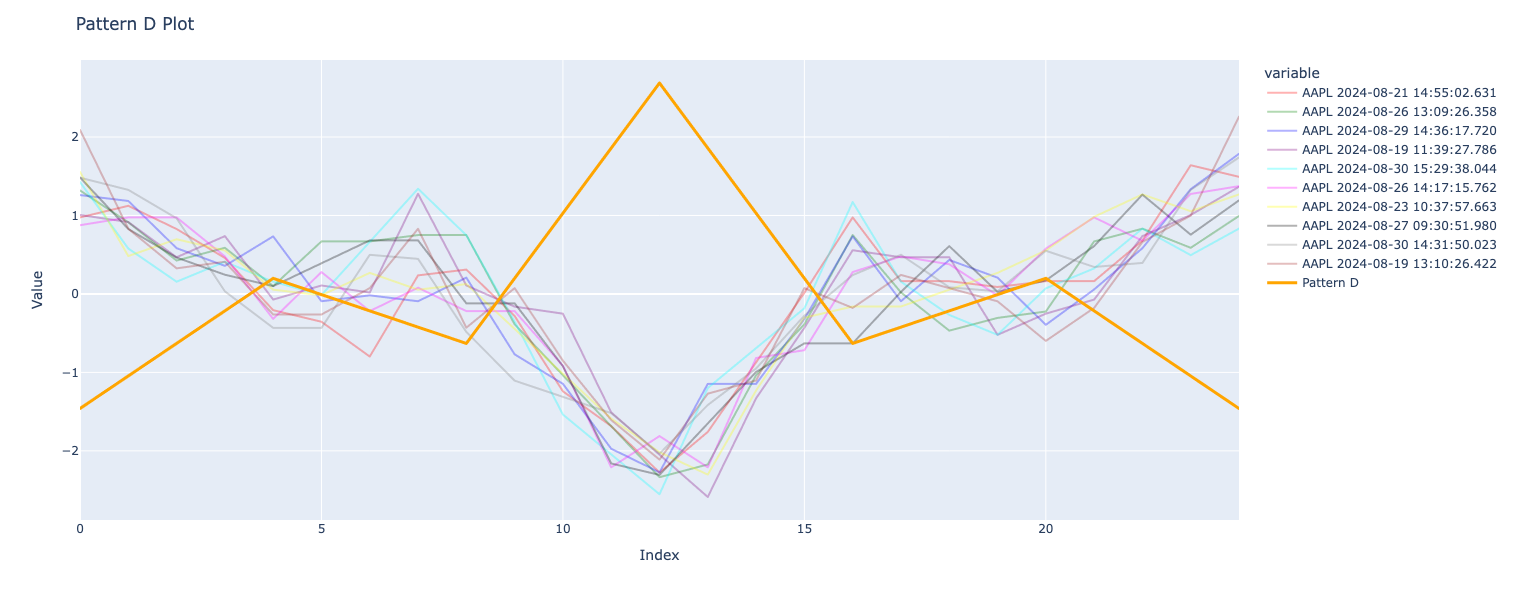

In [14]:
# List of pattern result names and pattern names
pattern_results = ['results[0]', 'results[1]', 'results[2]', 'results[3]']
pattern_names = ['Pattern A', 'Pattern B', 'Pattern C', 'Pattern D']
pattern_p = ['patterns[0]', 'patterns[1]', 'patterns[2]', 'patterns[3]']

# Process and plot each pattern in a loop
for i in range(4):
    pattern_df, nnMatch_df, q = process_pattern(pattern_results[i], pattern_p[i])
    
    # Plot using the normalized nnMatch_df
    print(pattern_df.head())
    fig = plot_pattern(nnMatch_df, q, pattern_names[i])
    fig.show()

In [15]:
%%q

pattern:patternA 96;
k:-1;
filters:{(enlist(=;`sym;enlist x))} each `AAPL`ADBE`AMZN`GOOG`META`MSFT`NFLX`NVDA`PYPL`TSLA;

\ts results: `nnDist xasc raze {
    res:gw(`search;`database`table`type`vectors`n`filter`options!(`default;`trade;`tss;enlist[`price]!enlist enlist pattern;k;x;enlist[`returnMatches]!enlist 1b));
    first res`result } each filters;

results

5189 20736
date       sym  time                          price  size nnIdx  nnDist   nnMatch                                                                            ..
-------------------------------------------------------------------------------------------------------------------------------------------------------------..
2024.08.26 AAPL 2024.08.26D14:21:37.801000000 245.42 18   74894  19.11445 245.42 245.44 245.46 245.37 245.33 245.34 245.32 245.28 245.3  245.28 245.25 245.23..
2024.08.23 ADBE 2024.08.23D11:39:02.408000000 587.89 17   132963 19.11782 587.89 587.82 588    587.92 587.71 587.41 587.08 586.75 586.86 586.82 586.57 586.43..
2024.08.21 AMZN 2024.08.21D13:01:55.822000000 147.03 66   254390 19.13734 147.03 146.98 147.03 147.06 147.04 147.03 146.97 146.95 146.92 146.89 146.86 146.82..
2024.08.20 NFLX 2024.08.20D14:18:03.328000000 426.14 89   673542 19.14207 426.14 426.1  426.1  426.07 425.86 425.96 425.9  425.94 425.71 425.47 425.39 425.36..
2024.08.27 META 2024.08.27D11

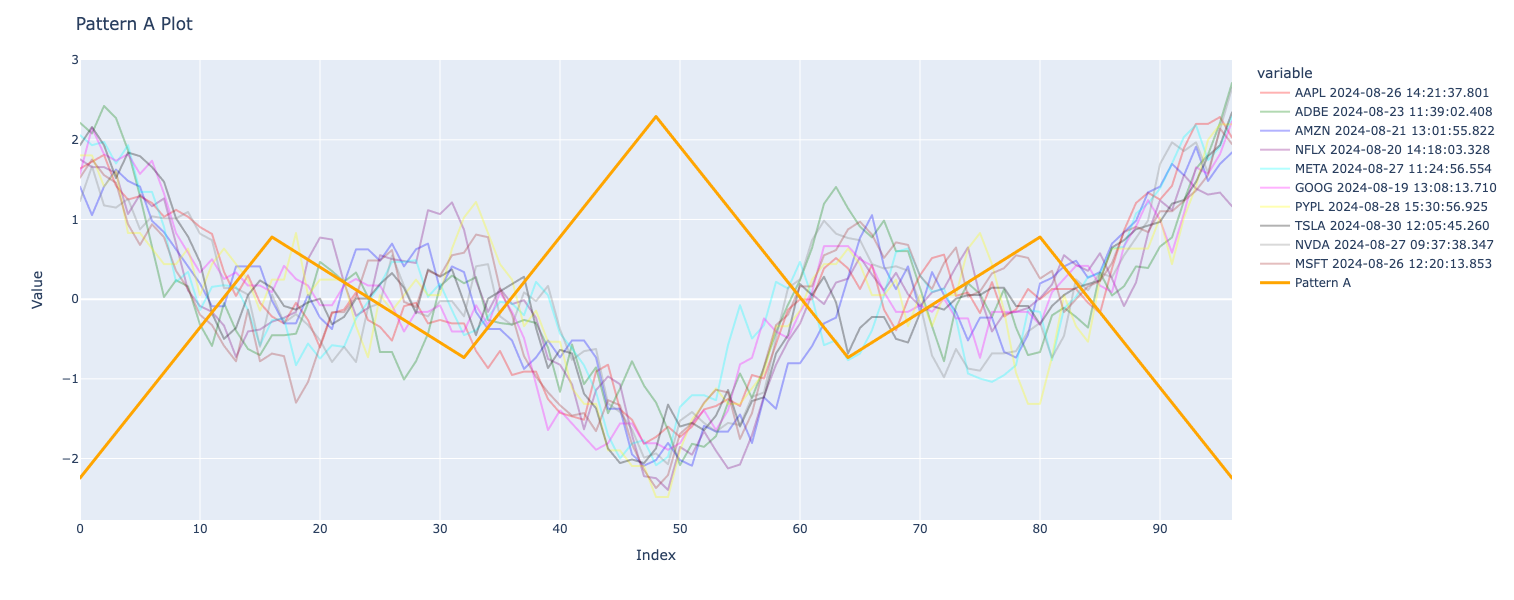

In [16]:
# Process the pattern and nearest neighbours
pattern_df, nnMatch_df, q = process_pattern('results', 'pattern')

# Plot the result
fig = plot_pattern(nnMatch_df, q, 'Pattern A')

# Show the figure
fig.show()

## 5. Drop the Table
Once finished with the table, it is best practice to drop it.

In [17]:
%%q

gw(`deleteTable;`database`table!`default`trade);

res:gw(`listTables;enlist[`database]!enlist`default)
res`result

database| `default
tables  | ()
